In [3]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the new models
def build_1d_cnn(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(inp)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = Conv1D(256, 15, padding='same', activation='relu')(x)
    x = Conv1D(1, 15, padding='same', activation='tanh')(x)
    return Model(inp, x)

def build_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_gru(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_denoising_autoencoder(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    encoded = Conv1D(128, 15, padding='same', activation='relu')(inp)
    encoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    
    # Decoder (without upsampling to maintain the same input/output size)
    decoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    decoded = Conv1D(128, 15, padding='same', activation='relu')(decoded)
    decoded = Conv1D(1, 15, padding='same', activation='tanh')(decoded)
    
    return Model(inp, decoded)

# Ensemble method: averaging predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    ensemble_prediction = np.mean(predictions, axis=0)
    return ensemble_prediction.squeeze()

# Load ECG and noise data
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}  # Modify this based on the classes you want to classify
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1  # Filter out invalid labels

# Filter data and labels to only include valid classes
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, combined_noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Add single noises to combined noises
noises = [em_noise, bw_noise, ma_noise]

snr_db = 0  # Example SNR value

# Prepare the clean ECG segments as target data for training
clean_ecg_segments_train = X_train.copy()

# Create noisy training data by combining all noise types
noisy_ecg_slices_train = add_combined_noise(X_train, noises, snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, noises, snr_db)

# Instantiate the models
models = [
    build_1d_cnn(),
    build_lstm(),
    build_gru(),
    build_denoising_autoencoder()
]

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the models
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train each model
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(clean_ecg_segments_train, axis=-1), 
              epochs=1, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Evaluate the trained models on each noise type and combination
noisy_ecg_slices_test = add_combined_noise(X_test, noises, snr_db)

# Denoise and classify
denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

# Calculate SNR and RMSE
snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

test_labels = y_test[:len(features_noisy)]

model_noisy = classify_heartbeats(features_noisy, test_labels)
model_denoised = classify_heartbeats(features_denoised, test_labels)

# Predict the classes
predictions_noisy = model_noisy.predict(features_noisy)
predictions_denoised = model_denoised.predict(features_denoised)

# Get the unique classes present in test_labels
unique_classes = np.unique(test_labels)
class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

# Evaluate accuracy for each class
report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

# Output the results for the combined noise
results = {
    'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
    'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    'snr': np.mean(snr_values),
    'rmse': np.mean(rmse_values)
}

print(f"Average SNR after denoising: {results['snr']:.4f} dB")
print(f"Average RMSE after denoising: {results['rmse']:.4f}")
print("Noisy data accuracies:")
for class_label, accuracy in results['noisy'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("Denoised data accuracies:")
for class_label, accuracy in results['denoised'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("\n")


529/529 ━━━━━━━━━━━━━━━━━━━━ 212s 395ms/step - loss: 0.0722 - val_loss: 0.0401
529/529 ━━━━━━━━━━━━━━━━━━━━ 455s 829ms/step - loss: 0.1033 - val_loss: 0.0648
529/529 ━━━━━━━━━━━━━━━━━━━━ 410s 745ms/step - loss: 0.0992 - val_loss: 0.0455
529/529 ━━━━━━━━━━━━━━━━━━━━ 121s 222ms/step - loss: 0.0805 - val_loss: 0.0378
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
Average SNR after denoising: 0.8871 dB
Average RMSE after denoising: 0.1521
Noisy data accuracies:
  N: 0.9983
  V: 0.7321
  A: 0.0925
  L: 0.9099
Denoised data accuracies:
  N: 0.9927
  V: 0.5114
  A: 0.0590
  L: 0.7831




In [4]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the new models
def build_1d_cnn(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(inp)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = Conv1D(256, 15, padding='same', activation='relu')(x)
    x = Conv1D(1, 15, padding='same', activation='tanh')(x)
    return Model(inp, x)

def build_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_gru(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_denoising_autoencoder(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    encoded = Conv1D(128, 15, padding='same', activation='relu')(inp)
    encoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    
    # Decoder (without upsampling to maintain the same input/output size)
    decoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    decoded = Conv1D(128, 15, padding='same', activation='relu')(decoded)
    decoded = Conv1D(1, 15, padding='same', activation='tanh')(decoded)
    
    return Model(inp, decoded)

# Ensemble method: averaging predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    ensemble_prediction = np.mean(predictions, axis=0)
    return ensemble_prediction.squeeze()

# Load ECG and noise data
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}  # Modify this based on the classes you want to classify
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1  # Filter out invalid labels

# Filter data and labels to only include valid classes
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, combined_noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Add single noises to combined noises
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

snr_db = 0  # Example SNR value

# Prepare the clean ECG segments as target data for training
clean_ecg_segments_train = X_train.copy()

# Create noisy training data by combining all noise types
noisy_ecg_slices_train = add_combined_noise(X_train, [em_noise, bw_noise, ma_noise], snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, [em_noise, bw_noise, ma_noise], snr_db)

# Instantiate the models
models = [
    build_1d_cnn(),
    build_lstm(),
    build_gru(),
    build_denoising_autoencoder()
]

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the models
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train each model
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(clean_ecg_segments_train, axis=-1), 
              epochs=1, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Evaluate the trained models on each noise type and combination
results = {}

for noise_name, noise_data in noises_dict.items():
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

    # Denoise and classify
    denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

# Output the results for each noise condition
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")


529/529 ━━━━━━━━━━━━━━━━━━━━ 181s 335ms/step - loss: 0.0801 - val_loss: 0.0412
529/529 ━━━━━━━━━━━━━━━━━━━━ 336s 623ms/step - loss: 0.1153 - val_loss: 0.0558
529/529 ━━━━━━━━━━━━━━━━━━━━ 456s 843ms/step - loss: 0.0966 - val_loss: 0.0513
529/529 ━━━━━━━━━━━━━━━━━━━━ 175s 317ms/step - loss: 0.0716 - val_loss: 0.0366
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 235ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [1]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the new models
def build_1d_cnn(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(inp)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = Conv1D(256, 15, padding='same', activation='relu')(x)
    x = Conv1D(1, 15, padding='same', activation='tanh')(x)
    return Model(inp, x)

def build_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_gru(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_denoising_autoencoder(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    encoded = Conv1D(128, 15, padding='same', activation='relu')(inp)
    encoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    
    # Decoder (without upsampling to maintain the same input/output size)
    decoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    decoded = Conv1D(128, 15, padding='same', activation='relu')(decoded)
    decoded = Conv1D(1, 15, padding='same', activation='tanh')(decoded)
    
    return Model(inp, decoded)

# Ensemble method: averaging predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    ensemble_prediction = np.mean(predictions, axis=0)
    return ensemble_prediction.squeeze()

# Load ECG and noise data
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}  # Modify this based on the classes you want to classify
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1  # Filter out invalid labels

# Filter data and labels to only include valid classes
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, combined_noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Add single noises to combined noises
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

snr_db = 0  # Example SNR value

# Prepare the clean ECG segments as target data for training
clean_ecg_segments_train = X_train.copy()

# Create noisy training data by combining all noise types
noisy_ecg_slices_train = add_combined_noise(X_train, [em_noise, bw_noise, ma_noise], snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, [em_noise, bw_noise, ma_noise], snr_db)

# Instantiate the models
models = [
    build_1d_cnn(),
    build_lstm(),
    build_gru(),
    build_denoising_autoencoder()
]

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the models
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train each model
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(clean_ecg_segments_train, axis=-1), 
              epochs=10, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Evaluate the trained models on each noise type and combination
results = {}

for noise_name, noise_data in noises_dict.items():
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

    # Denoise and classify
    denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

# Output the results for each noise condition
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")


Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 87s 163ms/step - loss: 0.0796 - val_loss: 0.0442
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 94s 178ms/step - loss: 0.0432 - val_loss: 0.0438
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 92s 175ms/step - loss: 0.0378 - val_loss: 0.0321
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 92s 174ms/step - loss: 0.0364 - val_loss: 0.0315
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 154s 291ms/step - loss: 0.0337 - val_loss: 0.0300
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 146s 276ms/step - loss: 0.0319 - val_loss: 0.0306
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 171s 322ms/step - loss: 0.0341 - val_loss: 0.0295
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 171s 323ms/step - loss: 0.0282 - val_loss: 0.0301
Epoch 9/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 170s 321ms/step - loss: 0.0334 - val_loss: 0.0293
Epoch 10/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 141s 267ms/step - loss: 0.0322 - val_loss: 0.0284
Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 126s 236ms/step - loss: 0.1147 - val_loss: 0.0742
Epoch 2/10
52

Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 309s 566ms/step - loss: 0.0876 - val_loss: 0.0429
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 304s 574ms/step - loss: 0.0514 - val_loss: 0.0361
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 300s 567ms/step - loss: 0.0380 - val_loss: 0.0350
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 274s 517ms/step - loss: 0.0410 - val_loss: 0.0338
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 298s 564ms/step - loss: 0.0354 - val_loss: 0.0310
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 297s 559ms/step - loss: 0.0357 - val_loss: 0.0299
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 296s 558ms/step - loss: 0.0321 - val_loss: 0.0292
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 300s 567ms/step - loss: 0.0311 - val_loss: 0.0336
Epoch 9/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 293s 554ms/step - loss: 0.0341 - val_loss: 0.0286
Epoch 10/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 237s 448ms/step - loss: 0.0304 - val_loss: 0.0366
Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 386s 709ms/step - loss: 0.1073 - val_loss: 0.0625
Epoch 2/1

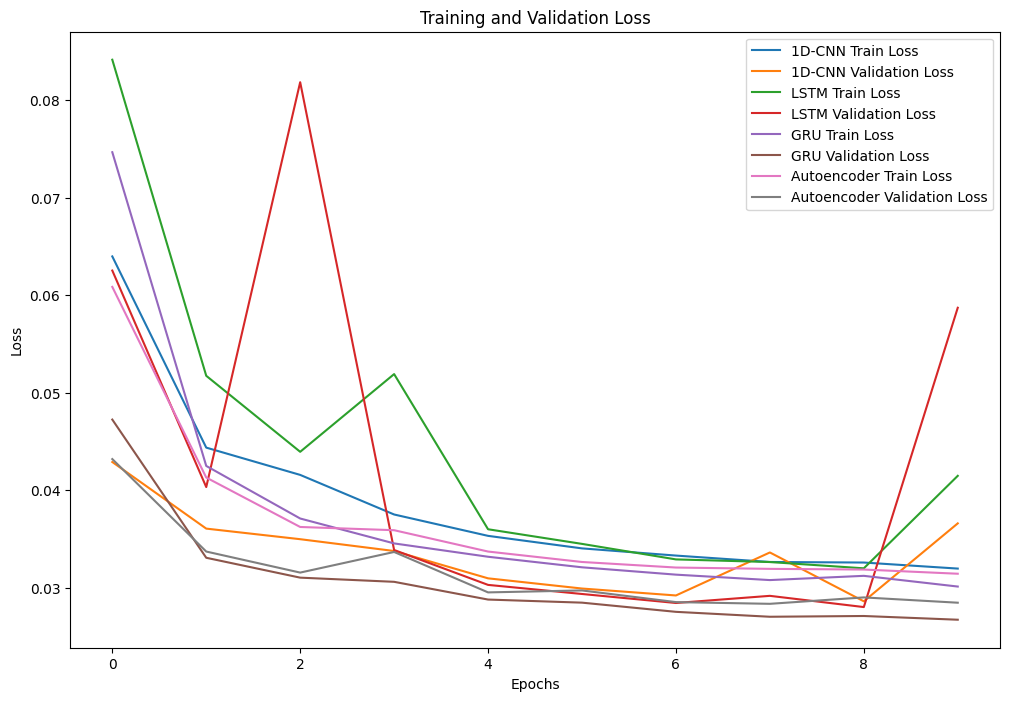

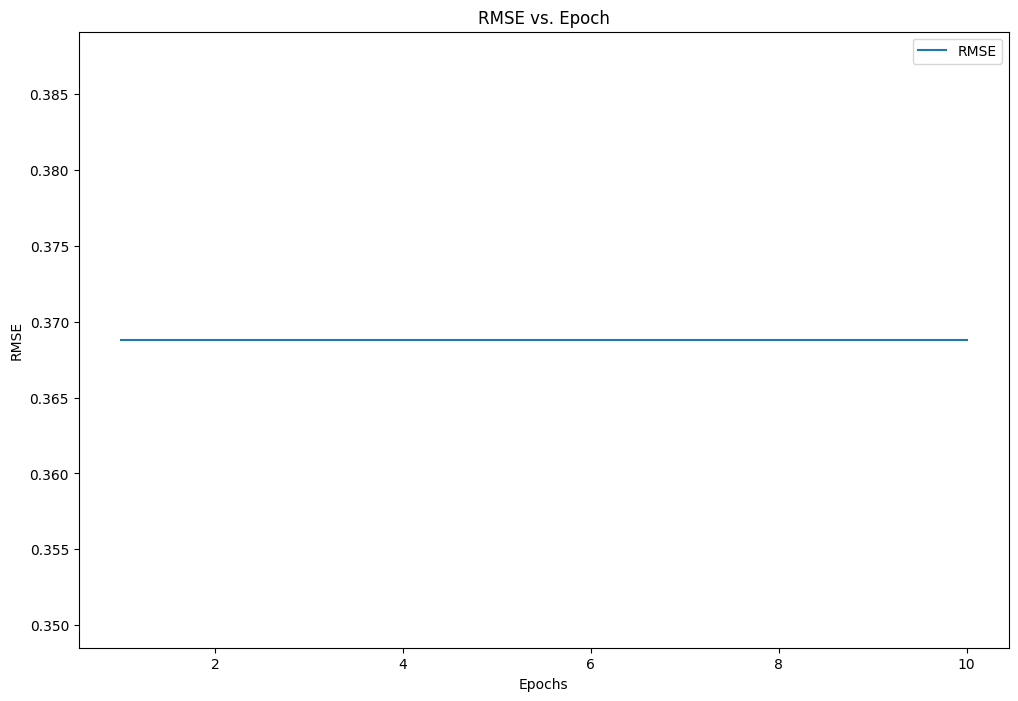

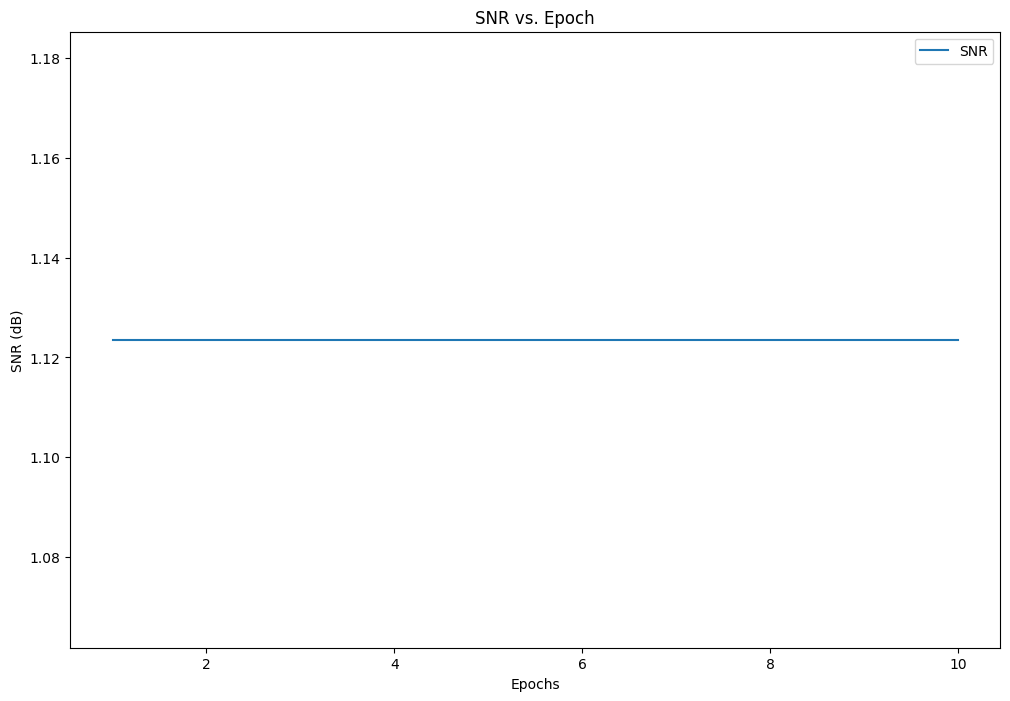

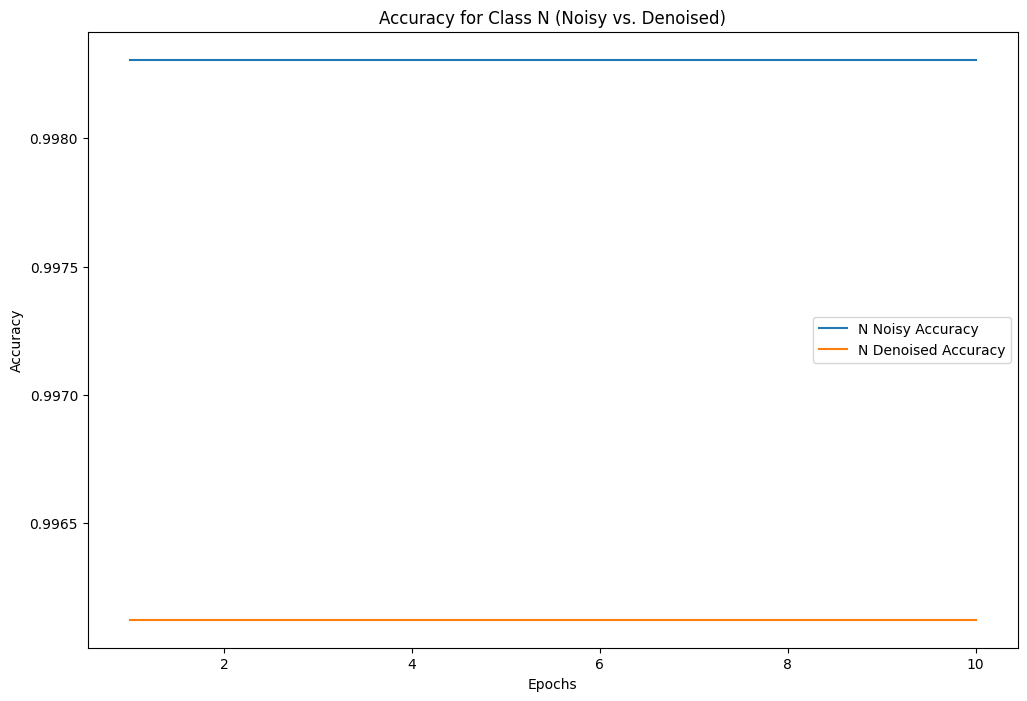

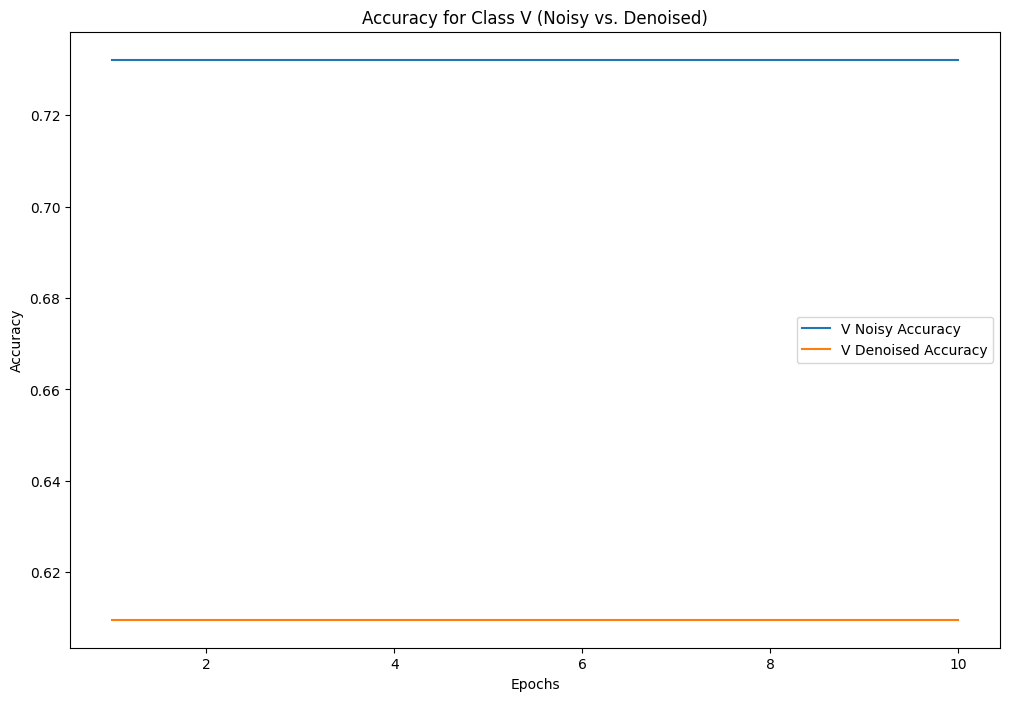

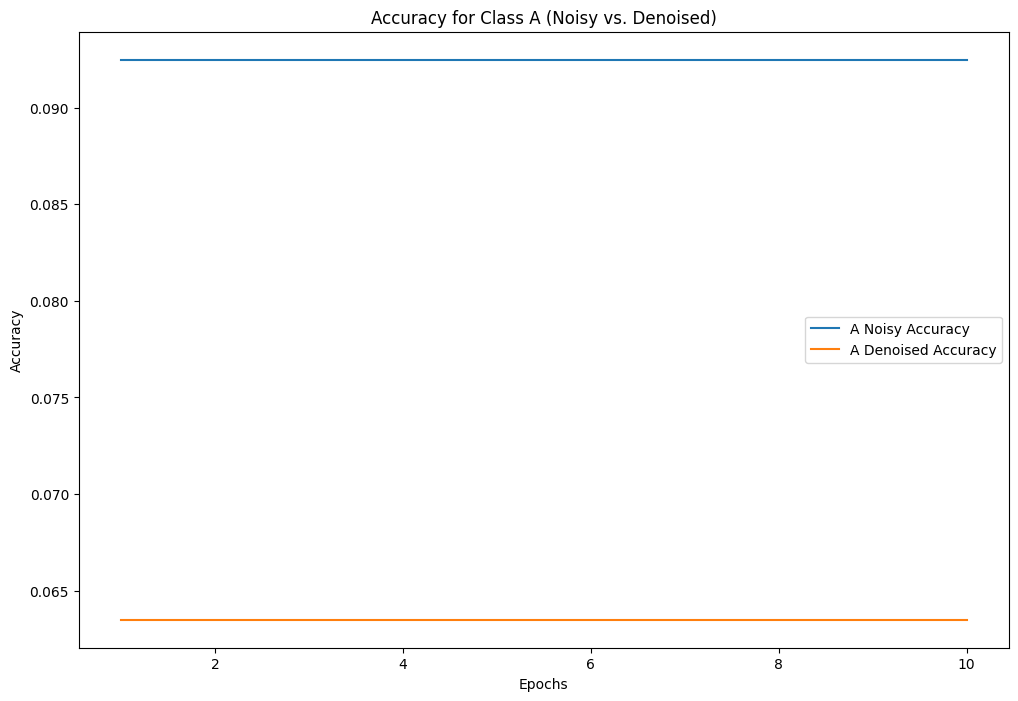

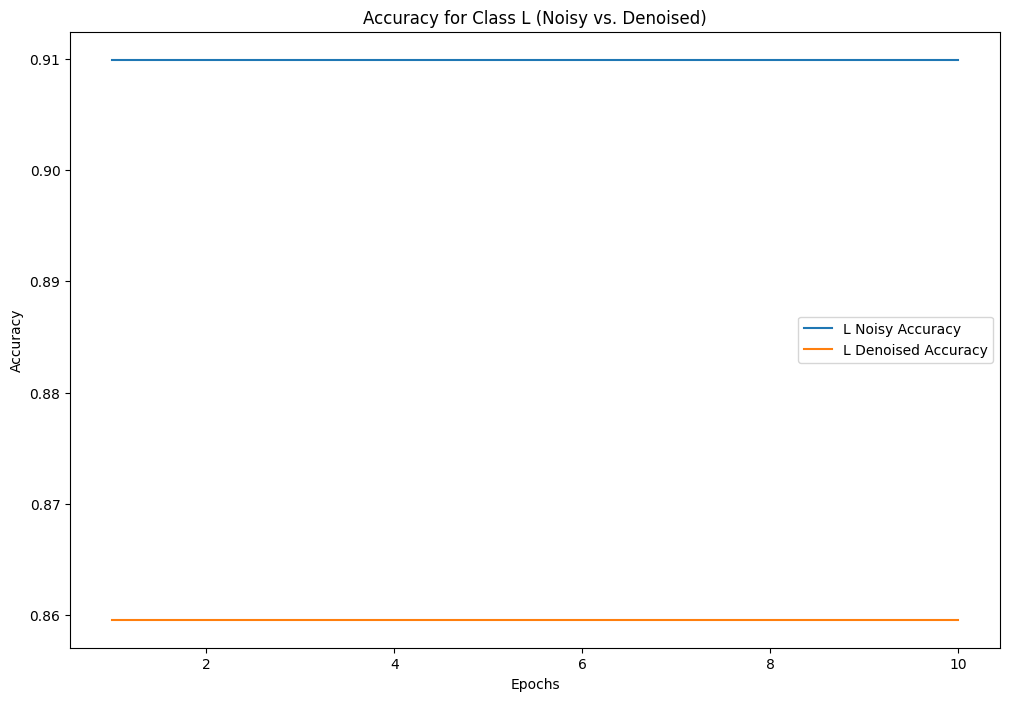

In [3]:
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the new models
def build_1d_cnn(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(inp)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = Conv1D(256, 15, padding='same', activation='relu')(x)
    x = Conv1D(1, 15, padding='same', activation='tanh')(x)
    return Model(inp, x)

def build_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_gru(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(inp, x)

def build_denoising_autoencoder(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    
    # Encoder
    encoded = Conv1D(128, 15, padding='same', activation='relu')(inp)
    encoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    
    # Decoder (without upsampling to maintain the same input/output size)
    decoded = Conv1D(64, 15, padding='same', activation='relu')(encoded)
    decoded = Conv1D(128, 15, padding='same', activation='relu')(decoded)
    decoded = Conv1D(1, 15, padding='same', activation='tanh')(decoded)
    
    return Model(inp, decoded)

# Ensemble method: averaging predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    ensemble_prediction = np.mean(predictions, axis=0)
    return ensemble_prediction.squeeze()

# Load ECG and noise data
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}  # Modify this based on the classes you want to classify
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1  # Filter out invalid labels

# Filter data and labels to only include valid classes
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data into 70% training, 15% validation, and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Add single noises to combined noises
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

snr_db = 0  # Example SNR value

# Prepare the clean ECG segments as target data for training
clean_ecg_segments_train = X_train.copy()

# Create noisy training data by combining all noise types
noisy_ecg_slices_train = add_combined_noise(X_train, [em_noise, bw_noise, ma_noise], snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, [em_noise, bw_noise, ma_noise], snr_db)

# Instantiate the models
models = [
    build_1d_cnn(),
    build_lstm(),
    build_gru(),
    build_denoising_autoencoder()
]

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the models
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Store training history
history = []

# Train each model and store history
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    hist = model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(clean_ecg_segments_train, axis=-1), 
                     epochs=10, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))
    history.append(hist.history)

# Evaluate the trained models on each noise type and combination
results = {}
epoch_snrs = []
epoch_rmses = []

for epoch in range(10):  # Assuming 10 epochs
    snr_values = []
    rmse_values = []
    for noise_name, noise_data in noises_dict.items():
        noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

        # Denoise and classify
        denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

        # Calculate SNR and RMSE
        snr_values_epoch = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
        rmse_values_epoch = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

        snr_values.append(np.mean(snr_values_epoch))
        rmse_values.append(np.mean(rmse_values_epoch))

    epoch_snrs.append(np.mean(snr_values))
    epoch_rmses.append(np.mean(rmse_values))

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[epoch] = {
        'snr': epoch_snrs[epoch],
        'rmse': epoch_rmses[epoch],
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

# Plotting

# Plot training and validation loss
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(['1D-CNN', 'LSTM', 'GRU', 'Autoencoder']):
    plt.plot(history[i]['loss'], label=f'{model_name} Train Loss')
    plt.plot(history[i]['val_loss'], label=f'{model_name} Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE vs Epoch
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), epoch_rmses, label='RMSE')
plt.title('RMSE vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plot SNR vs Epoch
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), epoch_snrs, label='SNR')
plt.title('SNR vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.legend()
plt.show()

# Plot accuracies for each class (Noisy vs Denoised)
for class_name in ['N', 'V', 'A', 'L']:
    plt.figure(figsize=(12, 8))
    noisy_accuracies = [results[epoch]['noisy'][class_name] for epoch in range(10)]
    denoised_accuracies = [results[epoch]['denoised'][class_name] for epoch in range(10)]
    plt.plot(range(1, 11), noisy_accuracies, label=f'{class_name} Noisy Accuracy')
    plt.plot(range(1, 11), denoised_accuracies, label=f'{class_name} Denoised Accuracy')
    plt.title(f'Accuracy for Class {class_name} (Noisy vs. Denoised)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [4]:
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

Noise type: 0
Average SNR after denoising: 1.1236 dB
Average RMSE after denoising: 0.3688
Noisy data accuracies:
  N: 0.9983
  V: 0.7321
  A: 0.0925
  L: 0.9099
Denoised data accuracies:
  N: 0.9961
  V: 0.6096
  A: 0.0635
  L: 0.8596


Noise type: 1
Average SNR after denoising: 1.1236 dB
Average RMSE after denoising: 0.3688
Noisy data accuracies:
  N: 0.9983
  V: 0.7321
  A: 0.0925
  L: 0.9099
Denoised data accuracies:
  N: 0.9961
  V: 0.6096
  A: 0.0635
  L: 0.8596


Noise type: 2
Average SNR after denoising: 1.1236 dB
Average RMSE after denoising: 0.3688
Noisy data accuracies:
  N: 0.9983
  V: 0.7321
  A: 0.0925
  L: 0.9099
Denoised data accuracies:
  N: 0.9961
  V: 0.6096
  A: 0.0635
  L: 0.8596


Noise type: 3
Average SNR after denoising: 1.1236 dB
Average RMSE after denoising: 0.3688
Noisy data accuracies:
  N: 0.9983
  V: 0.7321
  A: 0.0925
  L: 0.9099
Denoised data accuracies:
  N: 0.9961
  V: 0.6096
  A: 0.0635
  L: 0.8596


Noise type: 4
Average SNR after denoising: 1.1236 dB

In [5]:
# Plotting function for the noisy and denoised ECG signals
import matplotlib.pyplot as plt
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

# Plotting for all noise types
for noise_name, noise_data in noises.items():
    noisy_ecg_slices = add_noise_to_segments(ecg_segments, noise_data, snr_db)
    denoised_ecg_slices = denoise_signal(models, noisy_ecg_slices)
    
    # Generate plots
    plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices)

NameError: name 'noises' is not defined